# Value Based Order Location Anticipation

## Problem statement

In the context of ride-hailing, the availability of car supply depends on the duration of time it takes for the drivers to reach the customers. The code in the current jupyter notebook explores the viability of algorithmic order location anticipation based on the data provided to guide the driver towards areas of highest ride value.

The source data is approximately 630000 rows of synthetic ride demand data which resembles the real-life situation in the city of Tallinn. 

## Data exploration

In [1]:
# import all necessary library
import numpy as np
from scipy import stats
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [2]:
# load data into pandas Data Frame for easy processing
data = pd.read_csv('robotex5.csv')

The best place to start when creating a model for new data is to explore and clean the data. Let's start by displaying a few first rows, column types, and basic statistics.

In [3]:
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [4]:
data.dtypes

start_time     object
start_lat     float64
start_lng     float64
end_lat       float64
end_lng       float64
ride_value    float64
dtype: object

In [5]:
# check general stats to spot any irregularities or outliers
data.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


The table above clearly shows that the dataset contains invalid inputs. Negative latitude and longitude correspond to coordinates in the Southern hemisphere. Given that the data contains only the rides in the Tallinn city area, these data points are erroneous. The exorbitant maximum value probably was the result of that error as well. 

Different methods exist to remove outliers. For instance, computing z-scores for every data entry can help to see how likely those events are to happen. A common practice is to eliminate data points with a z-score higher than 3 that have a very low probability of happening given the entire data sample (i.e., the probability of happening is beyond 3 sigmas). 

In [6]:
# remove start_time column to avoid porblems with computing scores on non-numeric values
columns = data.columns.tolist()
columns.remove('start_time')

# compute z-scores for all numeric columns and eliminate rows with z-score >= 3
data[columns] = data[columns][(np.abs(stats.zscore(data[columns])) < 3).all(axis=1)]
data.dropna(inplace=True)

# check general stasts again to make sure that outliers are now gone
data.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,608016.000000,608016.000000,608016.000000,608016.000000,608016.000000
mean,59.427875,24.742941,59.426886,24.744753,1.219575
std,0.018099,0.053151,0.035714,0.077573,1.207035
min,59.363413,24.572933,56.922764,22.219173,0.107628
25%,59.418899,24.713757,59.415303,24.708058,0.532250
50%,59.431871,24.744348,59.430707,24.744353,1.026000
75%,59.438636,24.765814,59.439267,24.773934,1.643250
max,59.493967,24.914064,61.552744,28.191449,71.246500


The outliers are now gone, however, it seems that the dataset still contains long rides outside the main city area. For the purpose of demonstration, those rides can also be eliminated to focus on a smaller area. Using the same technique as before but with a lower z-score isn't the right choice. Possible clusters of long rides may increase standard deviation and appear normal, whereas short but isolated rides within the close city area may become statistical outliers. 

The easier way to solve the problem is to eliminate the data belonging to the first and last percentiles. 

In [7]:
# get boolean pandas Series reflecting selection conditions
start_lat = data['start_lat'].between(data['start_lat'].quantile(.1), data['start_lat'].quantile(.99))
start_lng = data['start_lng'].between(data['start_lng'].quantile(.1), data['start_lng'].quantile(.99))
end_lat = data['end_lat'].between(data['end_lat'].quantile(.1), data['end_lat'].quantile(.99))
end_lng = data['end_lng'].between(data['end_lng'].quantile(.1), data['end_lng'].quantile(.99))

# retain only data entries satisfying the conditions
data = data[start_lat & start_lng & end_lat & end_lng]
data.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,407359.000000,407359.000000,407359.000000,407359.000000,407359.000000
mean,59.432185,24.753163,59.432335,24.756857,0.859712
std,0.011668,0.040302,0.016523,0.048824,0.588595
min,59.402140,24.676251,59.398458,24.664577,0.107628
25%,59.426350,24.728893,59.423581,24.725590,0.403765
50%,59.433954,24.748461,59.433265,24.749195,0.732000
75%,59.439390,24.768779,59.439974,24.775154,1.172500
max,59.472760,24.884441,59.508049,24.917342,4.161750


In [8]:
# check the time bounderies, since they are not shown in general stats
print(min(data['start_time']), max(data['start_time']))

2022-03-01 00:00:20.355945000 2022-03-28 23:59:53.175658000


Let's now take a smaller sample of data (e.g., all rides within a day) and visualize it by plotting it on a map.

In [9]:
# select samples for the first day in the dataset
sample = data[data['start_time'].between('2022-03-01 00:00:00', '2022-03-02 00:00:00')]

# transform latitude and longitude measurements into 2D coordinates 
start_geo = [Point(x,y) for x,y in zip(sample['start_lng'],sample['start_lat'])]
end_geo = [Point(x,y) for x,y in zip(sample['end_lng'],sample['end_lat'])]

# create geopandas dataframe describing the geometry of the sample
start_gdf = gpd.GeoDataFrame(sample, geometry=start_geo)
end_gdf = gpd.GeoDataFrame(sample, geometry=end_geo)

# load the map of Tallinn
city_gdf = ox.geocode_to_gdf('Tallinn')

For the sake of simplicity, the latitude and longitude measurements were directly projected to Euclidean space, as geometrical distortions on a smaller scale are negligible.

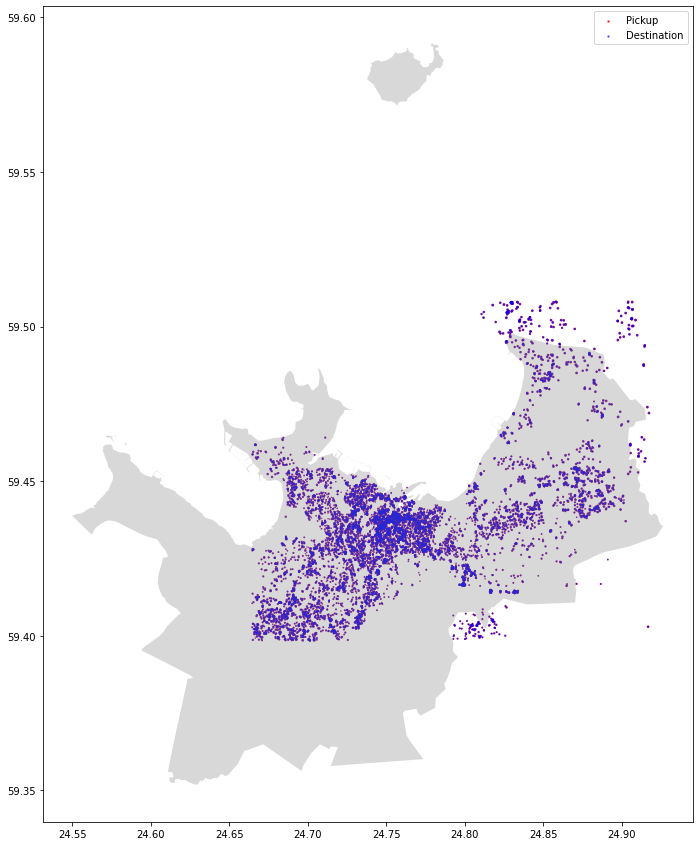

In [10]:
# plot pickup and destination locations for selected rides on a map
fig, ax = plt.subplots(figsize=(15, 15))
start_gdf.plot(ax=ax, marker='o', color='red', alpha = 0.7, markersize=sample['ride_value'], label='Pickup');
end_gdf.plot(ax=ax, marker='o', color='blue', alpha = 0.5, markersize=sample['ride_value'], label='Destination');
city_gdf.plot(ax=ax, color="grey", alpha=0.3)
plt.legend()
plt.show()

## Model

The current baseline modeling approach follows a simple idea: based on the historical data, compute a rectangular grid heatmap indicating areas with higher ride values and high demand. Every cell on the heatmap is a combination of several factors: number of rides starting at that area, the total value generated by the pickups in the area, and number of rides finishing at the area. 

Although drivers are guided to the areas where the rides start, the destination also plays an important role. The areas where both pickup and drop-off take place create a natural increase in supply and have to be prioritized more than the areas with unilateral movement.

Because supply and demand fluctuate with time, it is important to be able to slice the date and anticipate the demand according to relevant time intervals. One would also expect to see seasonality patterns in this type of data. Thus, the code below allows data aggregation according to the following intervals: minutes, hours, calendar days, days of week, and months. 

In [11]:
# choose time aggregation interval (in standard datetime frequency format) and the size of the grid
TIME_INTERVAL = '1H'
GRID_SIZE = 25

For simplicity, the grid has the same number of cells in both directions, which means that each cell represents a rectangular area rather than a square one. However, because of the projection, the size of different cells measured in km will be different. Thus, in reality, the grid cells are not rectangles but quadrilateral polygons. 

Every pickup and destination location in the dataset has to be mapped to a grid cell, a.k.a indices in a 2D numpy array. Thus, a function transforming latitude and longitude coordinates into array indices has to be created.

In [12]:
# compute coordinate bounderies and grid steps in advance 
row_start = max(data['start_lat'].max(), data['end_lat'].max())
row_end = min(data['start_lat'].min(), data['end_lat'].min())
col_start = min(data['start_lng'].min(), data['end_lng'].min())
col_end = max(data['start_lng'].max(), data['end_lng'].max())
row_step = (row_end - row_start)/(GRID_SIZE)
col_step = (col_end - col_start)/(GRID_SIZE)

# function to map geographic coordinates into array indices
def coord_to_grid_cell(x,y):
    i = min(int((y - row_start)/row_step), GRID_SIZE-1)
    j = min(int((x - col_start)/col_step), GRID_SIZE-1)
    return i,j

In this example, both grid size and time aggregation interval can be adjusted. Their values are a trade-off between accuracy and computational speed/memory, and, in some sort, represent a margin of error. For example, a coarse grid requires less memory and computations but may lead to poorer results in terms of financial gains and supply optimum.

The code below computes intervals and group data entries according to provided interval frequency.

In [13]:
# transform start_time column from string to datetime format
data['interval'] = pd.to_datetime(data['start_time'])

# for dates
if TIME_INTERVAL in ['D']: 
    # drop the time and save only the date
    data['interval'] = pd.to_datetime(data['interval'].map(lambda x: x.date()))
    # group by datetime date
    interval_data = data.groupby(pd.Grouper(key='interval', freq=TIME_INTERVAL))
    intervals = [key.strftime('%Y-%m-%d') for key in interval_data.groups.keys()]

# for days of the week and months
elif TIME_INTERVAL in ['A', 'B']: 
    # to every row in the dataframe, assign the label corresponding to the aggregation interval it belongs to 
    data['interval'] = data['interval'].map(lambda x: x.date().strftime(f'%{TIME_INTERVAL}'))
    # group by the assigned labels
    interval_data = data.groupby(by=data['interval'])
    intervals = [key for key in interval_data.groups.keys()]

# for hours and minutes    
elif any(ti in TIME_INTERVAL for ti in ['H', 'min']): 
    # a small hack to be able to make correct aggregation - set the same date for all the rows
    today = datetime.today().date().strftime('%Y-%m-%d')
    data['interval'] = data['interval'].map(lambda x: f"{today} {x.time()}")
    data['interval'] = pd.to_datetime(data['interval'])
    # group by datetime time
    interval_data = data.groupby(pd.Grouper(key='interval', freq=TIME_INTERVAL))
    intervals = [key.strftime('%H:%M:%S') for key in interval_data.groups.keys()]

# raise an exception for unknown intervals
else:
    raise Exception(f"Time interval {TIME_INTERVAL} is not supported")

# visually verify created intervals
print(intervals)

['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']


In order to compute the heatmap efficiently, several 3D numpy arrays will be used. They have to be initialized first.

In [14]:
pickup = np.zeros([GRID_SIZE,GRID_SIZE,len(intervals)])
destination = np.zeros([GRID_SIZE,GRID_SIZE,len(intervals)])
value = np.zeros([GRID_SIZE,GRID_SIZE,len(intervals)])
norm_anticipation = np.zeros([GRID_SIZE,GRID_SIZE,len(intervals)])

For every ride, the cells corresponding to pickup and destination areas will be incremented. Whereas, the value will be summed with other values at the same pickup area. The function below captures this process.

In [15]:
def process_ride(ride, k):
    # compute array indices from georgaphical coordinates
    orig_i, orig_j = coord_to_grid_cell(ride['start_lng'], ride['start_lat'])
    dest_i, dest_j = coord_to_grid_cell(ride['end_lng'], ride['end_lat'])
    
    # record the ride in the provisioned arrays
    pickup[orig_i, orig_j, k] += 1
    destination[dest_i, dest_j, k] += 1
    value[orig_i, orig_j, k] += ride['ride_value']

To be able to have heatmaps per interval, each interval group has to be processed separetly.

In [16]:
for k, (_, df) in enumerate(interval_data):
    # process every ride in the current interval
    df.apply(process_ride, axis=1, k=k)

After all the rides are processed, the final anticipation heat map can be computed.

In [17]:
# first compute average value per area, taking care of possible division by zero
avg_value = np.divide(value, pickup, out=np.zeros_like(pickup), where=pickup!=0)

# weight average values by number of rides ending in the same area
anticipation = np.multiply(avg_value, destination)

# normalize the final heat map
for k in range(len(intervals)):
    norm_anticipation[:,:,k] = anticipation[:,:,k] / anticipation[:,:,k].sum()

Normalization is important to understand what portion of the total car supply has to be guided to each area. 

## Results

Finally, let's take one interval to display the results. In case we want to display several intervals, having a customized plot function is convenient.

In [18]:
def plot_interval_heatmaps(k, interval_name):
    fig, axs = plt.subplots(2,3, figsize=(15, 15))
    
    # plot all heatmaps
    axs[0, 0].imshow(pickup[:,:,k], cmap='hot', interpolation='none')
    axs[0, 1].imshow(destination[:,:,k], cmap='hot', interpolation='none')
    axs[0, 2].imshow(value[:,:,k], cmap='hot', interpolation='none')
    axs[1, 0].imshow(avg_value[:,:,k], cmap='hot', interpolation='none')
    axs[1, 1].imshow(norm_anticipation[:,:,k], cmap='hot', interpolation='none')
    
    # hacks to ignore last subplot that suppose to be empty
    axs[1, 2].imshow(np.zeros([GRID_SIZE,GRID_SIZE]))
    axs[-1, -1].cla()
    axs[-1, -1].axis('off')
    
    # set title for each heatmap
    fig.suptitle(f"Interval starting at {interval_name}", y=0.83, size=20)
    axs[0, 0].set_title('Pickup')
    axs[0, 1].set_title('Destination')
    axs[0, 2].set_title('Value')
    axs[1, 0].set_title('Average value')
    axs[1, 1].set_title('Anticipation')
    
    # set correct ticks showing the coordinates
    ticks = np.linspace(0, GRID_SIZE-1, 5)
    xticklabels = [f'{xt:.2f}' for xt in np.linspace(col_start, col_end, 5)]
    yticklabels = [f'{xt:.2f}' for xt in np.linspace(row_start, row_end, 5)]
    plt.setp(axs, xticks=ticks, xticklabels=xticklabels, yticks=ticks, yticklabels=yticklabels)
    
    # adjust layout
    fig.subplots_adjust(hspace=-0.7)
    plt.tight_layout()

Let's see what the heatmaps look like from 8:00 to 9:00 am.

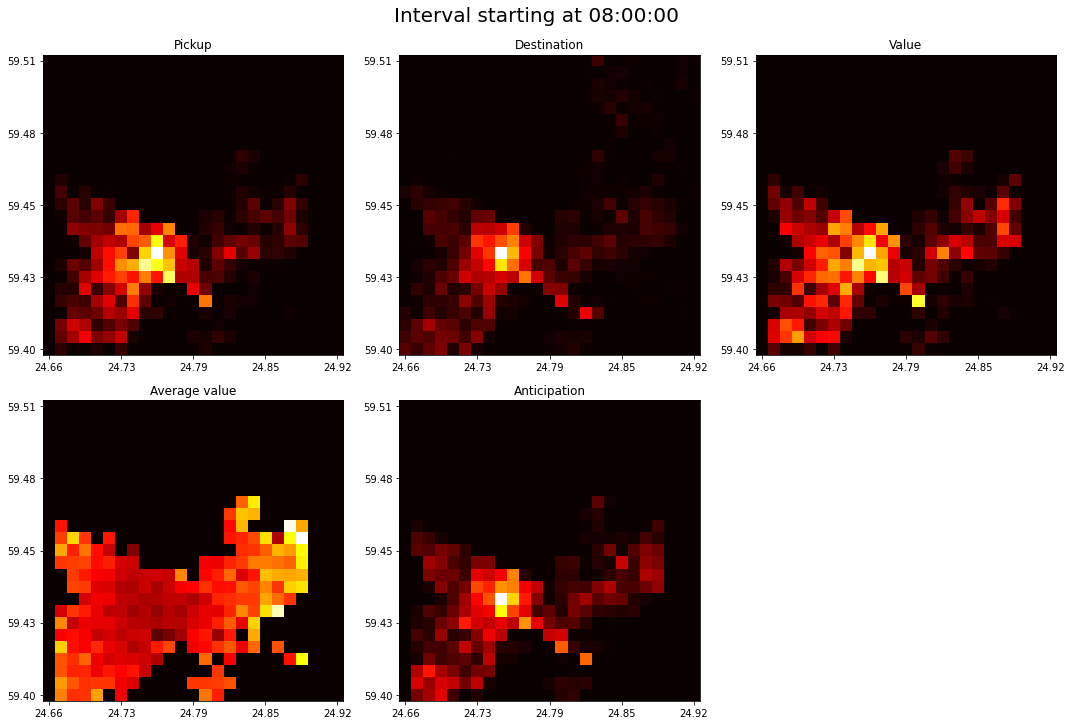

In [19]:
# set interval and get the corresponding array index
interval = '08:00:00'
k = intervals.index(interval)

# display the heatmaps for the selected interval
plot_interval_heatmaps(k, interval)

By looking at the average value heatmap, we can see that pickup locations in areas close to Pirita or Mustamäe are more lucrative, as customers probably are headed to the city center. However, because the overall demand is lower in those areas, the total value is higher in the city center and its surroundings. Nevertheless, according to the initial hypothesis and the final anticipation heatmap, in order to maximize profits, it is wise to guide more cars closer to the old town, where both pickups and drop-offs happen more frequently. Other time intervals may however reveal a slightly different picture, reflecting the corresponding demand and profits at that particular time.

The cells of the grid can be transformed back to geographical coordinates of the corresponding areas. Their normalized heat values will indicate the required portion of total circulating cars. 

## Additional variables

Even though the provided information is enough to create a simple baseline model guiding the drivers to locations with higher value and demand, other pieces of information would be very useful to build more complex optimization models. 

- Traveled distance is an important parameter to know for car flow optimization, as computing Euclidean or Manhattan distance based on geo-coordinates may lead to significant errors. The distance to the pickup location and the distance between the pickup location and destination are both important to know. This would allow to come up with a better scheduling algorithm but also reduce costs and carbon emissions. 
- Because the *start_time* variable only indicates the time when the order was made, there is no information about the time when the car actually arrived at the location and when the driver finished the ride. 
- It would also be useful to know the initial coordinates of the driver when he/she accepted the order or the coordinates of the preceding destination.
- Knowing the number of available cars at the time of order (globally and in the area of the order) may also be helpful.
- Finally, the *ride_value* variable seems to incorporate aggregated information about the price of the ride and incurred costs. Having access to that data separately would allow a deeper analysis. For example, a better understanding of the pricing algorithm and the possibility to investigate the correlation between price and time, as well as price and distance.

## Deployment

Deployment of a model involves consideration of several important factors. First of all, it requires the intergation of the model into an existing production environment. Integration strategy depends on the tech stack in production. If production code is also written in Python, the integration process is straightforward. If the main codebase uses a different language, two options are possible. The algorithm can be rewritten in that language. For such a simple model this shouldn't be a problem. Although optimization of matrix operations, which are core part of this model, is the key to success and should be addressed in production. Another option is to create a channel of communication between the main application and the model module, for example using REST API. In any case, the model code should be included in the CI-CD pipeline, and appropriate tests have to be written.

After the deployment, the model can be continuously updated with information about new rides to improve the results. To make this process efficient, parallelization has to be considered before the deployment. For example, new rides can be recorded to the *pickup*, *destination*, and *value* arrays in parallel. And then once in a while, according to a schedule, the lock on those arrays has to be placed in order to recompute the final *anticipation* heatmap.

Scalability is also one of the important aspects in production. Fortunately, the model has linear execution complexity and constant memory space complexity as regards to the number of new inputs for the update. Inference speed is also important. 
The speed and complexity of retrieval depend on the size of the grid and the granularity of interval aggregation. Both are constant for a given size and granularity level. Several tricks can accelerate computations. For instance, the transformation of geo-coordinates to grid indices and back can be done differently. Instead of computing the transform for every coordinate, a hash table can be used to store corresponding indices and vice versa. Thus the coordinates have to be truncated, depending on the acceptable level of error, in order to reduce the number of records in the hash table.

Finally, monitoring of the deployed solution also has to be performed to maintain a healthy status and high availability of the system.

## Evaluation

The efficacy of the model for live operations has to be evaluated after the deployment. The efficacy can be defined as the maximization of the total value for the company or minimization of waiting time for customers. A series of experiments can be carried out to perform the evaluation. Two main things have to be measured: 1) how different parameters of the model (grid size and time intervals) influence its results, and 2) how this model compares to an already existing model in production.

A/B tests can be performed to compare model parameters. For every experiment, only one parameter at a time should be altered. A random selection of rides has to be made. Statistical tests have to be used to measure the effect. 

To compare the current solution to the existing one, statistical tests rejecting or accepting the null hypothesis (i.e., *"New model has no effect on the targeted outcome of operations"*) have to be performed. Because we are aiming to improve existing results, a one-tailed test has to be used to compute the *p*-value.